# experiments

In [1]:
from sklearn.cluster import KMeans
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import rbf_kernel
from itertools import product
import matplotlib.pyplot as plt

In [2]:
def evaluate_model(y_train,y_train_mod, y_mod_pred):
	print("Number of label changes made in dataset: %d" % np.count_nonzero(y_train - y_train_mod))
	print("Model Accuracy w.r.t. Original dataset: ", 
          np.count_nonzero((y_train - y_mod_pred)==0)*100.0/y_train.shape[0])
	print("Model Accuracy w.r.t. Modified dataset: ", 
          np.count_nonzero((y_train_mod - y_mod_pred)==0)*100.0/y_train.shape[0],"\n")

In [3]:
def check_trusted_items(X_train,y_train,X_trust,y_trust, clf, combo=None, 
						train_cluster_labels=None, trust_cluster_labels=None, plot=False):

	clf.fit(X_train, y_train)
	y_train_pred = clf.predict(X_train)

	y_trust_pred = clf.predict(X_trust)

	# print("Plotting...")

	if np.array_equal(y_trust, y_trust_pred):
		print ("All trusted items predicted correctly by model, combo:",combo)
		if plot:
			plotting.plot_model(X_train, y_train, X_trust, y_trust, str(combo)+" Good", 
													train_cluster_labels, trust_cluster_labels)
		check = True
	else:
		print ("%d trusted items were incorrectly predicted. Continuing experiment..."%
               np.count_nonzero(y_trust-y_trust_pred))
		if plot:
			plot_model(X_train, y_train, clf, X_trust, y_trust, str(combo)+" Bad", 
		 											train_cluster_labels, trust_cluster_labels)
		check = False
	return clf, y_train_pred, y_trust_pred, check

In [4]:
def modify_labels(K, y_train, train_cluster_labels, combo, max_changes=np.inf):
	
	y_train_mod = np.copy(y_train)
	for i in range(K):
		y_train_mod[train_cluster_labels==i] = combo[i]
	
	num_changes = np.count_nonzero(y_train - y_train_mod)
	if num_changes>max_changes:
		# print(combo,"Too many changes to dataset:",num_changes,"\n")
		return None
	else:
		print(combo,"Changes to dataset:",num_changes,"\n")
		return y_train_mod

In [5]:
def modify_labels_trust(y_train,y_trust,y_trust_pred,train_cluster_labels,trust_cluster_labels,max_changes=np.inf):
	y_train_mod = np.copy(y_train)
	count = 0
	for i in range(len(y_trust_pred)):
		if y_trust_pred[i]!=y_trust[i]:
			print("Set Cluster",trust_cluster_labels[i],"to",y_trust[i])
			y_train_mod[train_cluster_labels==trust_cluster_labels[i]] = y_trust[i]
	num_changes = np.count_nonzero(y_train - y_train_mod)
	if num_changes>max_changes:
		print("Too many changes to dataset:",num_changes,"\n")
		return None
	else:
		return y_train_mod


In [33]:
def cluster_data(X_train, y_train, X_trust, y_trust, clf, 
                 min_K, max_K, max_changes=np.inf, try_all_combos=False, plot=False, cluster_with_labels=False):
    
    label_set = list(set(y_train))

    # Visualize original dataset
    print("Running Model without any modifications to dataset...")

    clf, y_pred, y_trust_pred, check = check_trusted_items(X_train,y_train,X_trust,y_trust,clf, plot=plot)
    print("Number of bugs: %d" % np.count_nonzero(y_train - y_pred))
    evaluate_model(y_train,y_train, y_pred)

    if check:
        print("All trusted items classified correctly using original dataset! \n")

    print()

    if try_all_combos:
        print("Trying all labeling of clusters, from K = %d to %d\n"%(min_K,max_K))
    else:
        print("Modifying only labels of clusters containing mislabeled trusted items, from K = %d to %d\n"%(min_K,max_K))
    
    print(X_train.shape,y_train.shape)
    if cluster_with_labels:
        X_train_cluster = np.hstack((X_train, np.reshape(y_train,(y_train.shape[0],1))))
        X_trust_cluster = np.hstack((X_trust, np.reshape(y_trust,(y_trust.shape[0],1))))
    else:
        X_train_cluster = np.copy(X_train)
        X_trust_cluster = np.copy(X_trust)
    
    for K in range(min_K,max_K+1):
        kmeans = KMeans(n_clusters=K)
        kmeans.fit(X_train_cluster)

        train_cluster_labels = kmeans.labels_
        trust_cluster_labels = kmeans.predict(X_trust_cluster)

        if try_all_combos:
            print("Brute Force Clustering for K=%d"%K)
            all_combos = list(product(label_set, repeat=K)) 
            # this list contains every possible combination of labels for each cluster
            
            for combo in all_combos:
                if len(set(combo))<=1:
                    continue

                
                y_train_mod = modify_labels(K, y_train, train_cluster_labels, combo, max_changes=max_changes)
                if y_train_mod is None:
                    continue

                print(combo,":",)
                clf, y_mod_pred, _, check = check_trusted_items(X_train,y_train_mod,X_trust,y_trust, clf, combo, 
                                                                train_cluster_labels, trust_cluster_labels)
                
                evaluate_model(y_train,y_train_mod, y_mod_pred)
        else:
            print("Trusted Clustering for K=%d"%K)
            y_train_mod = modify_labels_trust(y_train,y_trust,y_trust_pred,train_cluster_labels,trust_cluster_labels,max_changes=max_changes)
            if y_train_mod is None:
                continue

            # print(y_trust_pred,y_trust)
            # print "List of points whose labels were changed:",[i for i in range(len(y_train)) if y_train[i]!=y_train_mod[i]]
            # print(train_cluster_labels,trust_cluster_labels)


            clf, y_mod_pred, _, check = check_trusted_items(X_train,y_train_mod,X_trust,y_trust, clf, 
                                                        "Trusted clustering: %d"%K, train_cluster_labels, 
                                                        trust_cluster_labels, plot=plot)
            
            evaluate_model(y_train,y_train_mod,y_mod_pred)

    plt.show()

# plotting

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

In [9]:
# ----------------------------------------
# For plotting data
def plot_model(X_train, y_train, clf, X_trust=None, y_trust=None, title=None, 
													train_cluster_labels=None, trust_cluster_labels=None):
	
	pca = PCA(n_components=2)
	X_train_2d = pca.fit_transform(X_train)
	X_trust_2d = pca.transform(X_trust)

	# X = np.zeros((10000,2))
	# a = np.linspace(0,1,100)
	# b = np.linspace(0,1,100)
	# e, d = np.meshgrid(a, b)
	# X[:,0] = np.reshape(e,(10000,))
	# X[:,1] = np.reshape(d,(10000,))

	# Z = clf.predict(X)
	# probs = clf.predict_proba(K)[:, 1].reshape(e.shape)

	plt.figure()

	# Put the result into a color plot
	# Z = Z.reshape(e.shape)
	# plt.contour(e, d, probs, levels=[0.5])

	# Plot clusters
	if train_cluster_labels is not None:
		if trust_cluster_labels is not None:
			cluster_labels = np.concatenate([train_cluster_labels,trust_cluster_labels])
			X = np.vstack([X_train_2d, X_trust_2d])
			plt.scatter(X[:, 0], X[:, 1], c=cluster_labels, marker='o', s=80)
		else:
			plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=train_cluster_labels, marker='o', s=80)

	# Plot the training points
	plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, cmap=plt.cm.Paired, marker='.')
	
	# Plot the trusted points
	if X_trust_2d is not None:
		plt.scatter(X_trust_2d[:, 0], X_trust_2d[:, 1], c=y_trust, cmap=plt.cm.Paired, marker='X')

	if title is not None:
		plt.title(str(title))

	plt.xlabel('x1')
	plt.ylabel('x2')
	plt.draw()

# GermanLoan

In [10]:
import csv
from sklearn.cluster import KMeans
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics.pairwise import rbf_kernel
import sys
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [11]:
# read dataset
col_names = ['Checking Status', 'Duration','Credit History', 'Credit Amt','Purpose', 
              'Saving acc', 'Present emp since', 'Installment Rate',
             'Personal Status', 'Age', 'Other debtors', 'Present Residence since', 'Property',
              'Other installment plans', 'Housing', 'Existing credits',
             'Job', 'Num People', 'Telephone', 'Foreign Worker','a','b','c','d','Approval Status']

numerical = ['Duration','Credit Amt','Age']

print("Reading dataset...")
all_data = pd.read_csv("germanloan.csv", names=col_names)
print(all_data.shape)

n = all_data.shape[0]
X = all_data[all_data.columns.difference(['Approval Status'])]
y = all_data['Approval Status']
print(X.shape,y.shape)

Reading dataset...
(1000, 25)
(1000, 24) (1000,)


In [12]:
all_data.head(5)

,Checking Status,Duration,Credit History,Credit Amt,Purpose,Saving acc,Present emp since,Installment Rate,Personal Status,Age,...,Existing credits,Job,Num People,Telephone,Foreign Worker,a,b,c,d,Approval Status
0,1,6,4,12,5,5,3,4,1,67,...,0,0,1,0,0,1,0,0,1,1
1,2,48,2,60,1,3,2,2,1,22,...,0,0,1,0,0,1,0,0,1,2
2,4,12,4,21,1,4,3,3,1,49,...,0,0,1,0,0,1,0,1,0,1
3,1,42,2,79,1,4,3,4,2,45,...,0,0,0,0,0,0,0,0,1,1
4,1,24,3,49,1,3,3,4,4,53,...,1,0,1,0,0,0,0,0,1,2


In [13]:
# Set 1=good, -1=bad in y
y[y==2] = -1

In [15]:
scaler = StandardScaler()
X.loc[:,['Duration','Credit Amt']] = scaler.fit_transform(X.loc[:,['Duration','Credit Amt']].astype('float64'))

/u/g/o/gouthamr/.local/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [16]:
# partition dataset on the basis of age, threshold = 25
X_y = X[X['Age']<=25]
X_o = X[X['Age']>25]
y_y = y[X['Age']<=25]
y_o = y[X['Age']>25]
print(X_y.shape, X_o.shape)

(190, 24) (810, 24)


In [17]:
X_y.head(2)

,Age,Checking Status,Credit Amt,Credit History,Duration,Existing credits,Foreign Worker,Housing,Installment Rate,Job,...,Present Residence since,Present emp since,Property,Purpose,Saving acc,Telephone,a,b,c,d
1,22,2,0.966377,2,2.248194,0,0,1,2,0,...,1,2,1,1,3,0,1,0,0,1
10,25,2,-0.698019,2,-0.738668,1,1,1,1,0,...,1,2,1,1,2,0,0,0,0,1


In [18]:
# Remove age as a feature
del X_y['Age']
del X_o['Age']

print(X_y.shape, X_o.shape)

(190, 23) (810, 23)


In [19]:
# Converting to numpy arrays
X_young = X_y.values
X_old = X_o.values
y_young = y_y.values
y_old = y_o.values

In [20]:
print(X_young.shape, X_old.shape)

(190, 23) (810, 23)


In [21]:
# Random arrays for partitioning into A,B,C datasets
np.random.seed(123)
young = np.random.permutation(np.arange(X_young.shape[0]))
old = np.random.permutation(np.arange(X_old.shape[0]))

In [22]:
# --------------------------------------------------------------
print("Creating datasets A, B and C...")
# Create dataset A (trusted dataset)
X_A = np.concatenate((X_young[young[:20],:],X_old[old[:20],:]))
y_A = np.concatenate((y_young[young[:20]],y_old[old[:20]]))
# print(X_A.shape,y_A.shape)

# Create dataset B (buggy dataset)
X_B = np.concatenate((X_young[young[20:190],:],X_old[old[20:190],:]))
y_B = np.concatenate((y_young[young[20:190]],y_old[old[20:190]]))
# print(X_B.shape,y_B.shape)

# Create dataset C (ground truth)
X_C = X_old[old[190:],:]
y_C = y_old[old[190:]]
# print(X_C.shape,y_C.shape)

Creating datasets A, B and C...


In [23]:
# --------------------------------------------------------------
print("Training Model on dataset C...")

# the learner is hard coded to be logistic regression
lam = 5e-3	# L2 regularization weight of learner
# Training model f* on dataset C
clf = LogisticRegression(solver='lbfgs', C=lam)

# clf = AdaBoostClassifier()


clf.fit(X_C, y_C)
y_C_pred = clf.predict(X_C)

print("Creating trusted labels for dataset A...")
y_A_pred = clf.predict(X_A)

print("Number of label changes made in Dataset A to make it trusted: %d"%np.count_nonzero(y_A-y_A_pred)),"\n"
y_A = y_A_pred

Training Model on dataset C...
Creating trusted labels for dataset A...
Number of label changes made in Dataset A to make it trusted: 12


In [41]:
max_changes = 100
try_all_combos = False
plot = True
min_K = 5
max_K = 10
cluster_with_labels = False
cluster_with_labels = True

Running Model without any modifications to dataset...
2 trusted items were incorrectly predicted. Continuing experiment...
Number of bugs: 109
Number of label changes made in dataset: 0
Model Accuracy w.r.t. Original dataset:  67.94117647058823
Model Accuracy w.r.t. Modified dataset:  67.94117647058823 


Modifying only labels of clusters containing mislabeled trusted items, from K = 5 to 10

(340, 23) (340,)
Trusted Clustering for K=5
Set Cluster 3 to -1
Set Cluster 0 to -1
25 trusted items were incorrectly predicted. Continuing experiment...
Number of label changes made in dataset: 82
Model Accuracy w.r.t. Original dataset:  56.76470588235294
Model Accuracy w.r.t. Modified dataset:  80.88235294117646 

Trusted Clustering for K=6
Set Cluster 1 to -1
Set Cluster 5 to -1
11 trusted items were incorrectly predicted. Continuing experiment...
Number of label changes made in dataset: 42
Model Accuracy w.r.t. Original dataset:  67.3529411764706
Model Accuracy w.r.t. Modified dataset:  77.941

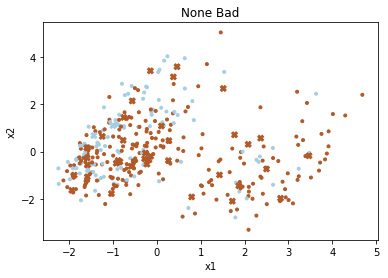

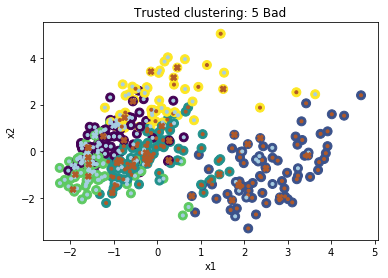

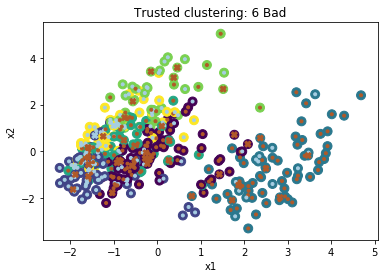

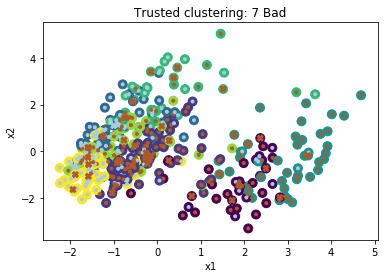

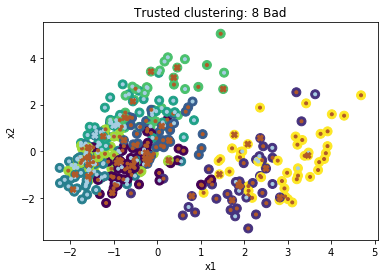

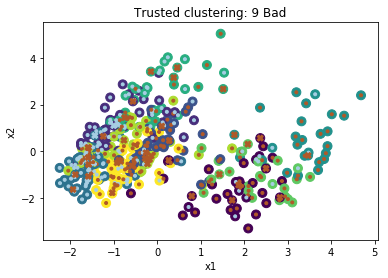

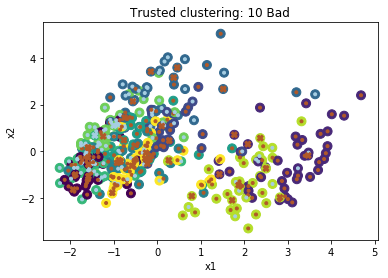

In [42]:
# --------------------------------------------------------------
# Experimenting with clustering

cluster_data(X_B, y_B, X_A, y_A, clf, min_K=min_K, max_K=max_K, 
             max_changes=max_changes,try_all_combos=try_all_combos, plot=plot, 
             cluster_with_labels=cluster_with_labels)